# An Example to Set the Stage

Before we start, here are some boring preliminaries to load the code to execute this notebook into your environment.

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

In [49]:
using DataFrames
using LaTeXStrings
using Logging
using StatsBase
using StatsPlots
using Turing

## It Was a Dark and Stormy Night...

...in the middle of the COVID 19 pandemic.  You are facing an unpleasant task (writing a grant proposal, cleaning the kitchen, etc) when your colleague [Jeff Kissell](https://scholar.google.com/citations?user=IrkY3dQAAAAJ&hl=en) emails you, asking for advice with the analysis of some measurements.  Jeff and his collaborators have been pushing on the LIGO mirrors gravitationally, using a rotating massive disk; they measure the response of the interferometer to the forcing at different frequencies, and can then calibrate the relation between mirror displacement (computed from the gravitational force law) and interferometer output.  Such calibration allows for accurate measurements of gravitational wave amplitudes.

The project eventually grew into {cite}`Ross2021`.  The data we have here are very preliminary versions of the data that can be found in that paper.

One feature of the measurements of interferometer response here is that the uncertainty in the measurement is *asymmetric*.  The data below give the "upper" and "lower" 1-sigma values (together these enclose 68% of the confidence interval of the measurement).  

There are two sets of measurements: one taken at the forcing frequencies of the rotor mass's quadrupole mass moment and one taken at the forcing frequencies of the rotor mass's octupole mass moment.  There are consistent units on the response and associated uncertainty, but we will ignore them for now; see {cite}`Ross2021` for the details.

In [6]:
quad_data = DataFrame([10.300 3.328e-11 1.706e-12 1.476e-12;
                       15.600 3.442e-11 1.027e-12 1.023e-12;
                       17.100 3.379e-11 9.777e-13 1.015e-12;
                       19.112 3.376e-11 9.033e-13 9.972e-13],
                      [:freq, :response, :sigma_upper, :sigma_lower])

,freq,response,sigma_upper,sigma_lower
,Float64,Float64,Float64,Float64
1,10.3,3.328e-11,1.706e-12,1.476e-12
2,15.6,3.442e-11,1.027e-12,1.023e-12
3,17.1,3.379e-11,9.777e-13,1.015e-12
4,19.112,3.376e-11,9.033e-13,9.972e-13


`DataFrames` can output summary statistics on the data:

In [8]:
describe(quad_data)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,freq,15.528,10.3,16.35,19.112,0,Float64
2,response,3.38125e-11,3.328e-11,3.3775e-11,3.442e-11,0,Float64
3,sigma_upper,1.1535e-12,9.033e-13,1.00235e-12,1.706e-12,0,Float64
4,sigma_lower,1.1278e-12,9.972e-13,1.019e-12,1.476e-12,0,Float64


In [7]:
oct_data = DataFrame([12.500 1.619e-11 5.142e-13 5.172e-13;
                      15.500 1.516e-11 4.521e-13 4.506e-13;
                      23.400 1.647e-11 3.830e-13 4.080e-13;
                      25.700 1.516e-11 3.047e-13 3.286e-13;
                      28.700 1.556e-11 2.839e-13 2.912e-13],
                     [:freq, :response, :sigma_upper, :sigma_lower])

,freq,response,sigma_upper,sigma_lower
,Float64,Float64,Float64,Float64
1,12.5,1.619e-11,5.142e-13,5.172e-13
2,15.5,1.516e-11,4.521e-13,4.506e-13
3,23.4,1.647e-11,3.83e-13,4.08e-13
4,25.7,1.516e-11,3.047e-13,3.286e-13
5,28.7,1.556e-11,2.839e-13,2.912e-13


In [9]:
describe(oct_data)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,freq,21.16,12.5,23.4,28.7,0,Float64
2,response,1.5708e-11,1.516e-11,1.556e-11,1.647e-11,0,Float64
3,sigma_upper,3.8758e-13,2.839e-13,3.83e-13,5.142e-13,0,Float64
4,sigma_lower,3.9912e-13,2.912e-13,4.08e-13,5.172e-13,0,Float64


Let's make a plot of the data, and see what it "looks like:"

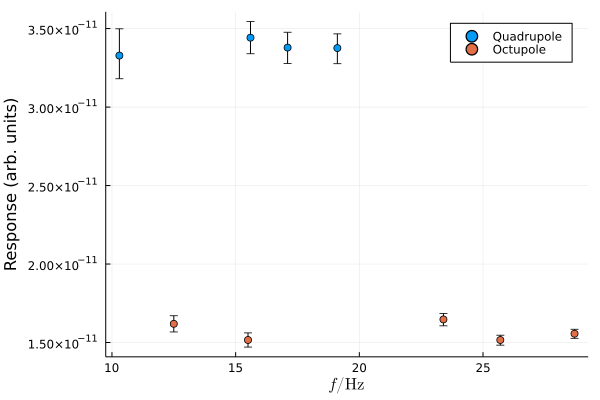

In [33]:
function plot_data(df, label; kwargs...)
    scatter!(df.freq, df.response; yerr=(df.sigma_lower, df.sigma_upper), label=label, kwargs...)
    xlabel!(L"f / \mathrm{Hz}")
    ylabel!("Response (arb. units)")
end
plot()
plot_data(quad_data, "Quadrupole")
plot_data(oct_data, "Octupole")

Looking at the above plot, it certainly seems reasonable enough to assume that there is one "quadrupole" and one "octupole" forcing response at all frequencies (i.e. that the measurements are all "consistent"---we will spend a long time discussing what that means in this course!---with each other).  Then you may remember formulas from your physics labs for combining the measurements.

If you don't, here they are: for a set of measurements $\{x_i \mid i = 1, \ldots, N \}$ with associated uncertainty $\{\sigma_i \mid i = 1, \ldots, N\}$ (here each $\sigma_i$ is assumed to be the square root of the measurement variance) of the same "true" quantity $x$, the "best" estimate of $x$, $\hat{x}$ is 

$$
  \hat{x} = \frac{\sum_i w_i x_i}{\sum_i w_i},
$$ (weighted_mean)

and the variance of the estimator is

$$
\DeclareMathOperator{\var}{var}
\var \hat{x} = \left( \sum_i w_i \right)^{-1}
$$ (variance_weighted_mean)

where 

$$
w_i = \frac{1}{\sigma_i^2}
$$ (weighted_mean_weights)

This function implements these formulas:

In [34]:
function mean_response_and_uncertainty(df)
    sigmas = (df.sigma_upper .+ df.sigma_lower) ./ 2
    wts = 1 ./ (sigmas.*sigmas)
    mr = (df.response' * wts) / sum(wts)
    mr_uncert = sqrt(1/sum(wts))
    (mr, mr_uncert)
end

mean_response_and_uncertainty (generic function with 1 method)

and applying them to our data sets yields:

In [35]:
((qr, qs), (or, os)) = mean_response_and_uncertainty(quad_data), mean_response_and_uncertainty(oct_data)

((3.3895423514377936e-11, 5.374742788398296e-13), (1.5620160113070848e-11, 1.6411225320059946e-13))

Or, graphically:

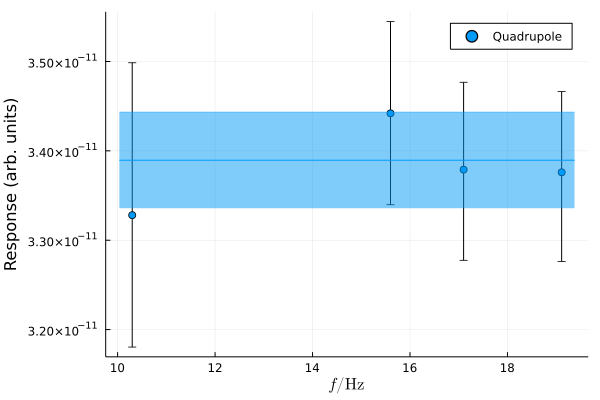

In [61]:
function plot_bands(r, s; color=1, alpha=0.5, kwargs...)
    x0, x1 = xlims()
    plot!([x0, x1], [r, r], color=color, label=nothing)
    plot!([x0, x1], [r+s, r+s]; fillrange=[r-s, r-s], color=color, alpha=alpha, kwargs...)
end

plot()
plot_data(quad_data, "Quadrupole")
plot_bands(qr, qs, color=1, label=nothing)

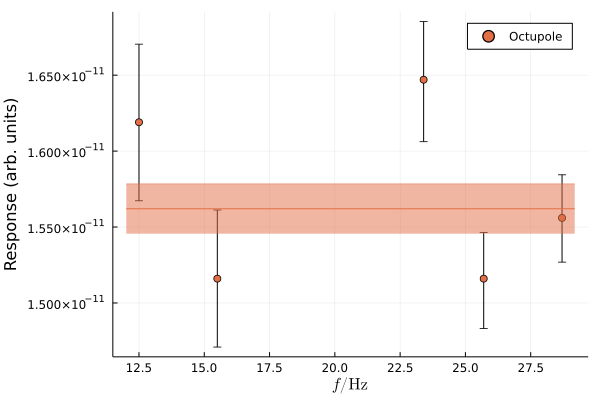

In [62]:
plot()
plot_data(oct_data, "Octupole", color=2)
plot_bands(or, os, color=2, label=nothing)

In [46]:
@model function scaled_errorbar(responses, sigmas)
    r_unit ~ Normal(0, 10)
    escale ~ LogNormal(log(1), 1)
    
    r = mean(responses) + std(responses)*r_unit
    
    responses ~ arraydist([Normal(r, escale*s) for s in sigmas])
    
    return (r=r, )
end

scaled_errorbar (generic function with 1 method)

In [55]:
scaled_quad_model = scaled_errorbar(quad_data.response, 0.5 .* (quad_data.sigma_lower .+ quad_data.sigma_upper))
scaled_quad_trace = sample(scaled_quad_model, NUTS(), 1000)
scaled_quad_genq = with_logger(NullLogger()) do # Sometimes this throws a lot of warnings that we don't care about.
    generated_quantities(scaled_quad_model, scaled_quad_trace)
end
scaled_quad_trace

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/Ysmbf/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×14×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.11 seconds
Compute duration  = 0.11 seconds
parameters        = escale, r_unit
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

      r_unit    0.1655    0.9361     0.0296    0.0394   269.5161    0.9990     ⋯
      escale    0.6207    0.4133     0.0131    0.0358   265.5180    1.0024     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

 

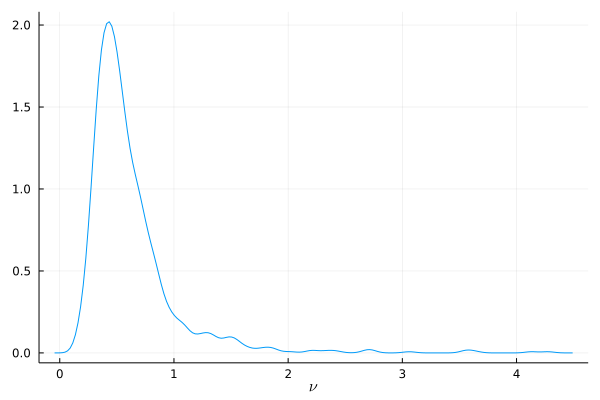

In [57]:
@df scaled_quad_trace density(:escale, xlabel=L"\nu", label=nothing)

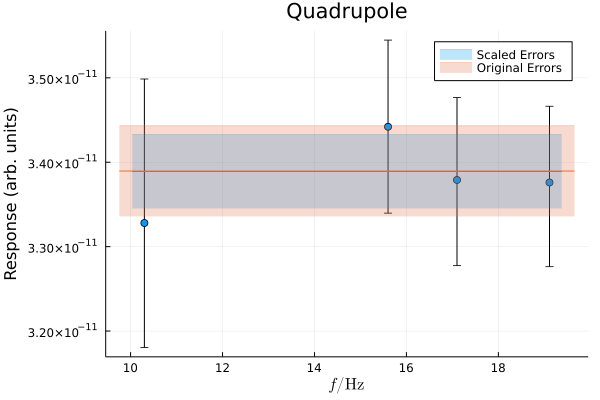

In [64]:
rq = vec([x.r for x in scaled_quad_genq])
plot()
plot_data(quad_data, nothing)
plot_bands(mean(rq), std(rq), color=1, label="Scaled Errors", alpha=0.25)
plot_bands(qr, qs, 2, color=2, label="Original Errors", alpha=0.25)
title!("Quadrupole")

In [65]:
scaled_oct_model = scaled_errorbar(oct_data.response, 0.5 .* (oct_data.sigma_lower .+ oct_data.sigma_upper))
scaled_oct_trace = sample(scaled_oct_model, NUTS(), 1000)
scaled_oct_genq = with_logger(NullLogger()) do # Sometimes this throws a lot of warnings that we don't care about.
    generated_quantities(scaled_oct_model, scaled_oct_trace)
end
scaled_oct_trace

┌ Info: Found initial step size
│   ϵ = 0.41250000000000003
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/Ysmbf/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×14×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.12 seconds
Compute duration  = 0.12 seconds
parameters        = escale, r_unit
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

      r_unit   -0.1470    0.5050     0.0160    0.0284   439.1369    1.0042     ⋯
      escale    1.7111    0.7184     0.0227    0.0411   298.2938    0.9990     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

 

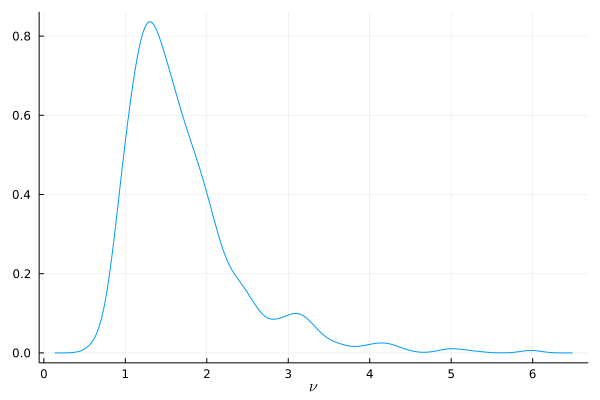

In [66]:
@df scaled_oct_trace density(:escale, xlabel=L"\nu", label=nothing)

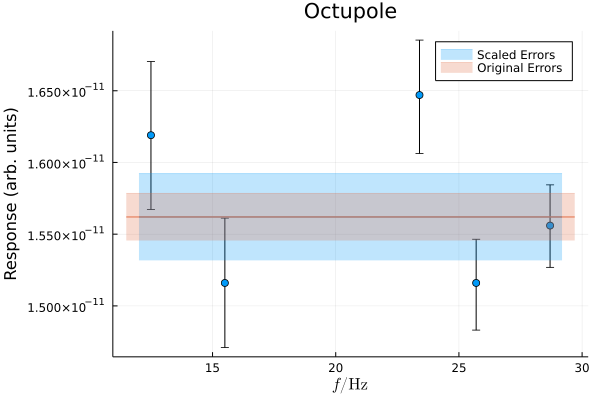

In [68]:
ro = vec([x.r for x in scaled_oct_genq])
plot()
plot_data(oct_data, nothing)
plot_bands(mean(ro), std(ro), color=1, label="Scaled Errors", alpha=0.25)
plot_bands(or, os, 2, color=2, label="Original Errors", alpha=0.25)
title!("Octupole")

In [77]:
@model function normal_hierarchical(responses, sigmas)
    mu_r_unit ~ Normal(0,1)
    sigma_r_unit ~ truncated(Normal(0,1), 0, Inf)
    r_unit ~ filldist(Normal(0,1), length(responses))
    
    mu_r = mean(responses) + std(responses)*mu_r_unit
    sigma_r = std(responses)*sigma_r_unit
    r = mu_r .+ sigma_r.*r_unit
    
    responses ~ arraydist([Normal(rr, s) for (rr,s) in zip(r, sigmas)])
    
    (mu_r=mu_r, sigma_r=sigma_r, r=r)
end

normal_hierarchical (generic function with 1 method)

In [78]:
nhq = normal_hierarchical(quad_data.response, 0.5 .* (quad_data.sigma_lower .+ quad_data.sigma_upper))
nht = sample(nhq, NUTS(), 1000)
nhg = with_logger(NullLogger()) do 
    generated_quantities(nhq, nht)
end

nht

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/Ysmbf/src/inference/hmc.jl:188


Chains MCMC chain (1000×18×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 3.26 seconds
Compute duration  = 3.26 seconds
parameters        = sigma_r_unit, mu_r_unit, r_unit[3], r_unit[2], r_unit[1], r_unit[4]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse         ess      rhat  ⋯
        Symbol   Float64   Float64    Float64   Float64     Float64   Float64  ⋯

     mu_r_unit    0.0547    0.7332     0.0232    0.0230    946.6228    1.0000  ⋯
  sigma_r_unit    0.6681    0.5061     0.0160    0.0234    764.7821    0.9998  ⋯
     r_unit[1]   -0.0695    0.9590     0.0303    0.0296   1142.4989    0.9990  ⋯
     r_unit[2]    0.1227    0.9432     0.0298    0.0271   1068.9487    0.9998  ⋯
     r_

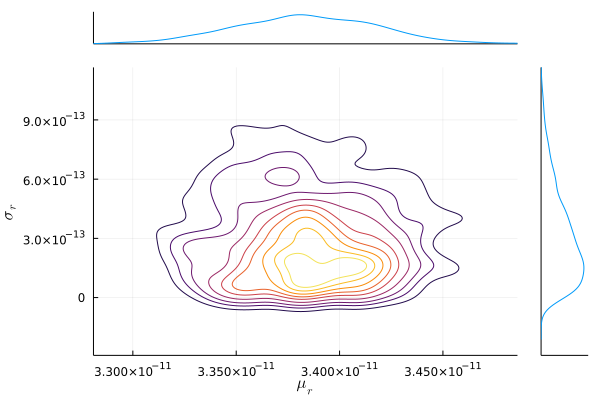

In [80]:
marginalkde(vec([x.mu_r for x in nhg]), vec([x.sigma_r for x in nhg]), xlabel=L"\mu_r", ylabel=L"\sigma_r")

In [82]:
nho = normal_hierarchical(oct_data.response, 0.5 .* (oct_data.sigma_lower .+ oct_data.sigma_upper))
nht = sample(nho, NUTS(), 1000)
nhg = with_logger(NullLogger()) do 
    generated_quantities(nho, nht)
end

nht

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/Ysmbf/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×19×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.27 seconds
Compute duration  = 0.27 seconds
parameters        = sigma_r_unit, mu_r_unit, r_unit[3], r_unit[2], r_unit[1], r_unit[4], r_unit[5]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse        ess      rhat   ⋯
        Symbol   Float64   Float64    Float64   Float64    Float64   Float64   ⋯

     mu_r_unit   -0.0757    0.4044     0.0128    0.0167   418.1793    1.0002   ⋯
  sigma_r_unit    0.6898    0.4226     0.0134    0.0289   358.6332    0.9994   ⋯
     r_unit[1]    0.3608    0.8478     0.0268    0.0393   802.9353    0.9996   ⋯
     r_unit[2]   -0.4208    0.7887     0.0249    0.0254   644.5201    0.9997 

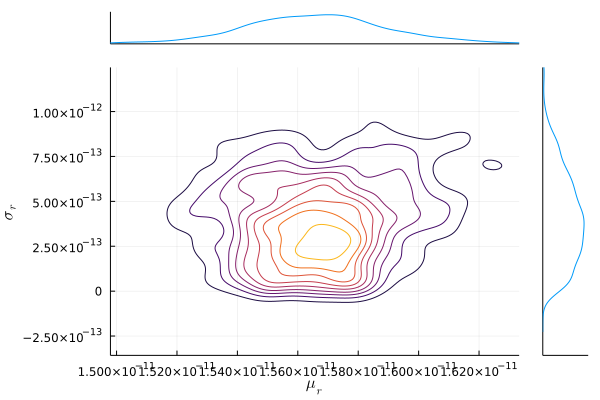

In [83]:
marginalkde(vec([x.mu_r for x in nhg]), vec([x.sigma_r for x in nhg]), xlabel=L"\mu_r", ylabel=L"\sigma_r")